In [51]:
cd("/home/jm2386/Active_Lattice/")
using DrWatson
@quickactivate "Active_Lattice"
include("/home/jm2386/Active_Lattice/src/pm_pdes.jl");
include("/home/jm2386/Active_Lattice/src/pm_sims.jl");
include("/home/jm2386/Active_Lattice/src/pm_plot.jl");
include("/home/jm2386/Active_Lattice/src/Hetrocline.jl");

v3.1
v3.0
v2.1


In [84]:
Pes = [5.0, 7.5]
axlims = [[0.0, 1.0, 0, 0.1], [0.0, 1.0, 0, 0.4]]
using PyPlot
PyPlot.close("all")
rc("text", usetex=true)
fig, axs = plt.subplots(1,2, figsize=(7.5,5))
for (ax, Pe, axlim) in zip(axs, Pes, axlims)
    # load binodal
        filename = "/store/DAMTP/jm2386/Active_Lattice/data/binodal/Pe=$(Pe).jld2"
        data = wload(filename)
        @unpack Pe, γs, ϕ1s, ϕ2s = data

    # plot binodal
        binod = ax.plot(gammas_converter_a(γs, ϕ1s), gammas_converter_p(γs, ϕ1s), color = "red", label = "Binodal")
        ax.plot(gammas_converter_a(γs, ϕ2s), gammas_converter_p(γs, ϕ2s), color = "red", label = "_Bindoal")
        #ax.plot(0.:0.1:1., 1.:-0.1:0., color = "black", label = "_Full")

        rc("text", usetex=true)
        ax.xaxis.set_ticks(0.:0.5:1.0)
        ax.yaxis.set_ticks(0.:0.1:0.4)
        ax.axis(axlim)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.xaxis.tick_bottom()
        ax.yaxis.set_tick_params(labelsize=15)
        
        #ax.set_title(L"\Re{ \lambda_n^\mathrm{max}} = 0",fontsize=20)
        ax.set_xlabel(L"\phi^a",fontsize=20)
        ax.set_ylabel(L"\phi^p", fontsize=20)
        # ax.legend(loc = "upper right", fontsize=20)
        # ax.set_aspect(0.25*Δρ/ΔPe)
        title = latexstring("\$ \\mathrm{Pe} = $(Pe)\$")
        ax.set_title(title,fontsize=20)
        ax.tick_params(labelbottom = true, direction = "in")
    #
    # plot spinodal
        ϕas_left, ϕas_right, ϕps = return_spin(;Pe = Pe, Δϕ = 0.0001)
        ax.plot(ϕas_left, ϕps, color = "blue", label = "_Spindoal", linestyle = "-")
        ax.plot(ϕas_right, ϕps, color = "blue", label = "_Spindoal", linestyle = "-")
end
fig.tight_layout()
#axs[2].legend(loc = "upper right", fontsize=20)
#display(fig)

In [85]:
param_sets = []
Pe = 5.0
    params = []
    ϕas = fill(0.6,5)
    ϕps = collect(0.01:0.01:0.05)
    DT, v0, DR, N, Δx, Lx, Ly, δt, δ = (1.0, 5.0, 1.0, 100, 0.02, 20.0, 0.5, 1e-4, 0.1);
    T, save_interval, param_name = (5000.0, 10.0, "fig_2")
    map(ϕas, ϕps) do ϕa, ϕp 
        param = new_param(DT, v0, DR, N, Δx, Lx, Ly, ϕa, ϕp, δt, δ; T = T, name = param_name, save_interval = save_interval, save_on = true)
        push!(params,param)
    end 
    push!(param_sets, params);
Pe = 7.5
    #create parameters
    params = []
    ϕas = fill(0.5,8)
    ϕps = collect(0.05:0.05:0.2)
    DT, v0, DR, N, Δx, Lx, Ly, δt, δ = (1.0, 7.5, 1.0, 100, 0.02, 20.0, 0.5, 1e-5, 0.01);
    T, save_interval, param_name = (4000.0, 100.0, "fig_2")
    map(ϕas, ϕps) do ϕa, ϕp
        param = new_param(DT, v0, DR, N, Δx, Lx, Ly, ϕa, ϕp, δt, δ; T = T, name = param_name, save_interval = save_interval, save_on = true)
        push!(params,param)
    end
    push!(param_sets, params);


In [86]:
for (i,(ax, params)) in enumerate(zip(axs, param_sets))
    ϕas = []
    ϕps = []
    for param in params
        local pde_ts, f_saves, f, t, ϕal, ϕag, ϕpl, ϕpg
        #load saves
        pde_ts, f_saves = load_compress_pde(param)
        f = f_saves[end]
        t = pde_ts[end]

        if t > 500
            rho = f[:,1] + f[:,2] + f[:,3]
            min_pt = argmax(rho)
            max_pt = argmin(rho)
            if min_pt<max_pt
                global x,X
                x = min_pt:1:max_pt
                X = min_pt:(max_pt-min_pt):max_pt
            else
                global x,X 
                x = max_pt:1:min_pt
                X = max_pt:(min_pt-max_pt):min_pt
            end


            ax.plot(f[X,1] + f[X,2], f[X,3], color = "black",linestyle = "-", label = "_gas phase", alpha = 0.5)

            ax.scatter(f[x,1] + f[x,2], f[x,3], color = "black", marker = ".", edgecolor = "black", s = 0.5*i^2, alpha = 1, label = "_gas phase")
            
            ϕal = maximum( f[x,1] + f[x,2])
            ϕag = minimum( f[x,1] + f[x,2])
            ϕpl = minimum( f[x,3] )
            ϕpg = maximum( f[x,3] )
        
            push!(ϕas, ϕal)
            push!(ϕas, ϕag)
            push!(ϕps, ϕpl)
            push!(ϕps, ϕpg)
        end
    end
    ax.scatter(ϕas, ϕps; color = "black", marker = "^", edgecolor = "black")
end
#display(fig)


full load


saved
full load


saved
full load


saved
full load


saved
full load


saved
fast load
fast load
fast load
fast load


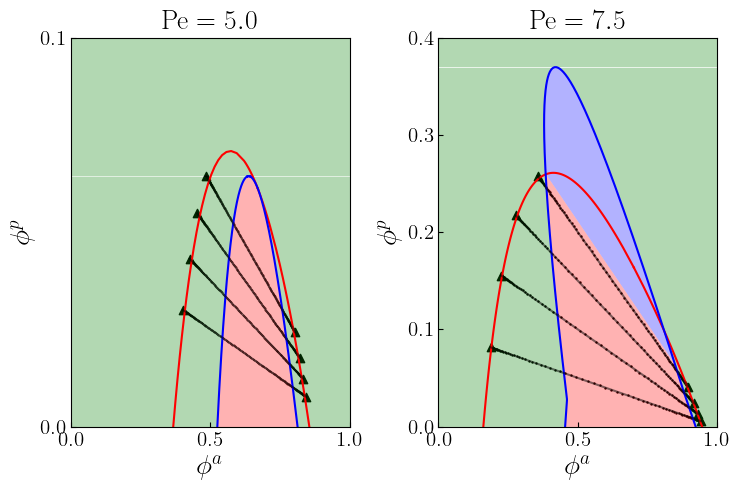

7.5

In [87]:
for (i,(ax,params)) in enumerate(zip(axs,param_sets))
    param = params[1]
            @unpack v0 = param
            Pe = v0
    # phase shading 
        if i ==1
            ϕas_left, ϕas_right, ϕps = return_spin(;Pe = Pe, Δϕ = 0.000001)
            ax.fill_betweenx(ϕps,ϕas_left,ϕas_right , color = "red", alpha = 0.3, linewidth = 0) 
            ax.fill_betweenx(ϕps,ϕas_left,0*ϕps, color = "green", alpha = 0.3, linewidth = 0) 
            ax.fill_betweenx(ϕps,ϕas_right,0*ϕps.+1, color = "green", alpha = 0.3, linewidth = 0) 
            ax.fill_betweenx([maximum(ϕps),1],[0,0], [1,1], color = "green", alpha = 0.3, linewidth = 0) 
        
        else
            ϕas_left, ϕas_right, ϕps = return_spin(;Pe = Pe, Δϕ = 0.0001)
            # load binodal
            filename = "/store/DAMTP/jm2386/Active_Lattice/data/binodal/Pe=$(Pe).jld2"
            data = wload(filename)
            @unpack Pe, γs, ϕ1s, ϕ2s = data
            print(Pe)
            # find final find gamma
            final_γ = 0.
            for (γ, ϕ1, ϕ2) in zip(γs, ϕ1s, ϕ2s)
                if (is_stable_value(gamma_converter(γ, ϕ1)...; Pe = Pe)>0)|(is_stable_value(gamma_converter(γ, ϕ2)...; Pe = Pe)>0)
                    final_γ = γ
                    break
                end
            end
            # shading
            tie_line_x = -ϕps*final_γ/(final_γ-1).+1
            ax.fill_betweenx(ϕps,max.(tie_line_x,ϕas_left),ϕas_right, max.(tie_line_x,ϕas_left) .≤ ϕas_right , color = "blue", alpha = 0.3, linewidth = 0) 
            ax.fill_betweenx(ϕps,ϕas_left,min.(tie_line_x,ϕas_right), ϕas_left .≤ min.(tie_line_x,ϕas_right) , color = "red", alpha = 0.3, linewidth = 0) 
            ax.fill_betweenx(ϕps,ϕas_left,0*ϕps, color = "green", alpha = 0.3, linewidth = 0) 
            ax.fill_betweenx(ϕps,ϕas_right,0*ϕps.+1, color = "green", alpha = 0.3, linewidth = 0) 
            ax.fill_betweenx([maximum(ϕps),1],[0,0], [1,1], color = "green", alpha = 0.3, linewidth = 0) 
        end
end
display(fig)

In [88]:
#display(fig)
fig_name = "bin_spin_plot"
    pathname = "/store/DAMTP/jm2386/Active_Lattice/plots/pm_figs/$(fig_name)";
    mkpath(pathname)
    filename = "/store/DAMTP/jm2386/Active_Lattice/plots/pm_figs/$(fig_name)/bin_spins.pdf";
    PyPlot.savefig(filename,dpi = 100, format = "pdf") #bbox_extra_artists=( ldg,)


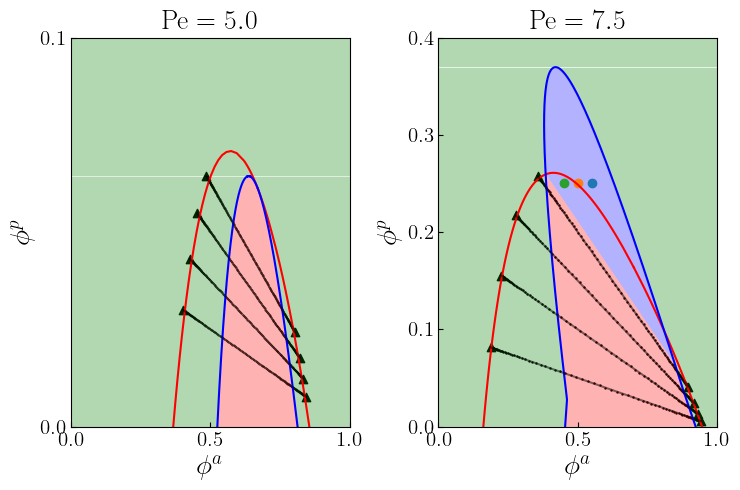

In [91]:
axs[2].scatter(0.45,0.25)
display(fig)

In [ ]:
# parameters
Pe = 7.5;
initial_Δ = 1e-5;
max_iter = 60;
tol = 1e-12;
atol = 1e-14;
rho_max = (1-1e-20);
#quick solve
Pe = 7.5;
γ_limit = find_gamma_limit(;Pe = Pe, initial_Δ = initial_Δ, γ_max = 100.)
#set Γ range
Γ = collect(1:0.01:γ_limit)
for i in 4:1:10
    γ1 = round(γ_limit, RoundDown; digits= i-2)
    γ2 = round(γ_limit, RoundDown; digits= i)
    Γ = append!(Γ,collect(γ1:(10.0^(-i)):γ2))
end
# println(Γ)
#solve over Γ
Pes = []
    γs = []
    ϕ1s = []
    ϕ2s = []
    approx = []
    errors = []
for γ in Γ
    find_sol = false
    try 
        find_sol, lower_limits, upper_limits = colapse_sol_interval(;Pe = Pe, γ = γ, rho_max = rho_max, initial_Δ = initial_Δ, max_iter = max_iter, tol = tol, atol = atol)
        if find_sol
            push!(ϕ1s,lower_limits[1])
            push!(ϕ2s,upper_limits[1])
            push!(γs, γ)
        end
    catch
            println("no solution Pe=$(Pe), γ=$(γ)")
            push!(errors,γ)
    end
end
average_ϕs = (ϕ1s+ ϕ2s)./2
χs = chis_converter(γs, average_ϕs)

#save results
using JLD2
    data = Dict{String,Any}()
    @pack! data = Pe, γs, ϕ1s, ϕ2s, average_ϕs, χs
    filename = "/store/DAMTP/jm2386/Active_Lattice/data/binodal/Pe=$(Pe).jld2"
    wsave(filename,data)
